In [9]:
import os
import torch
import joblib
import matplotlib


from mpp.utils.data_processing import DataProcessor
from mpp.utils.model_utils import train_and_evaluate_models
from mpp.models.neural_network import NeuralNetworkModel
from mpp.models.random_forest import RandomForestModel
from mpp.models.gradient_boosting import GradientBoostingModel
from mpp.models.knn import BaselineKNN
from mpp.utils.visualization import plot_correlation_matrix, plot_results, plot_training_process, plot_multiple_training_processes, plot_feature_correlations
from mpp.tuning.tune import HyperparameterTuning

import warnings
warnings.filterwarnings('ignore')

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [11]:
def model_exists(model_path):
    return os.path.exists(model_path)

In [12]:
# Load the data
processor = DataProcessor("data/data.csv")
data = processor.load_data()
data_with_features = processor.extract_features()

In [13]:
# Split the data
X_train, X_test, y_train_pic50, y_test_pic50, y_train_logP, y_test_logP = processor.split_data()

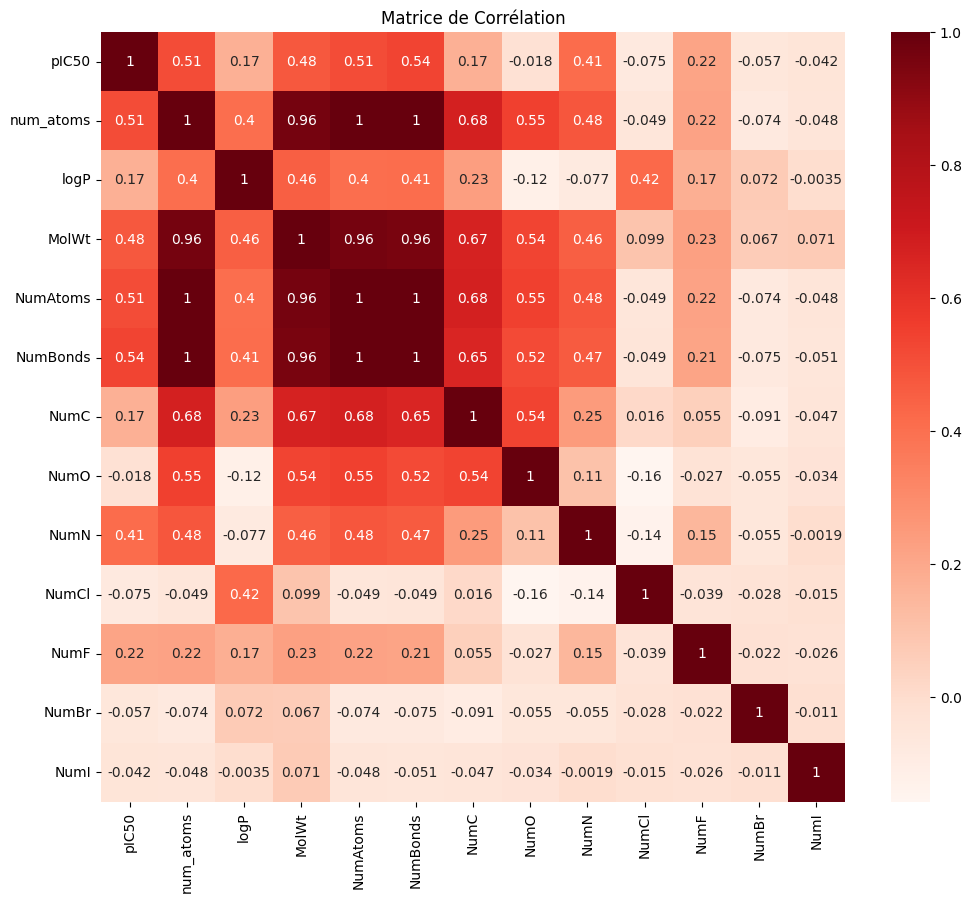

In [14]:
# Feature visualization
plot_correlation_matrix(data_with_features)

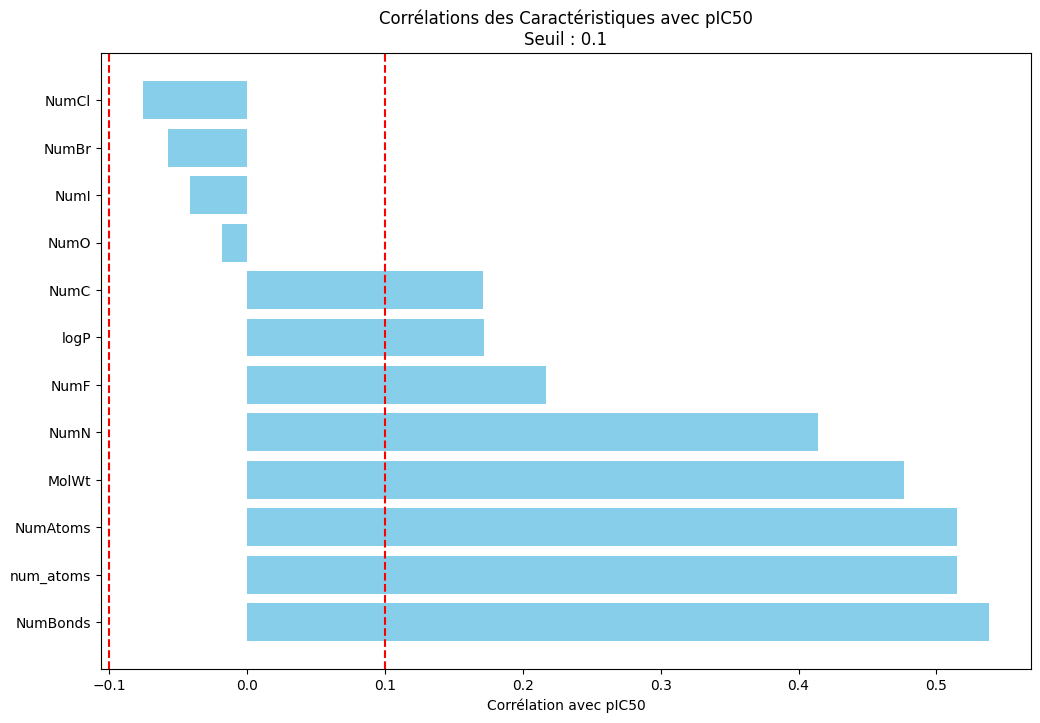

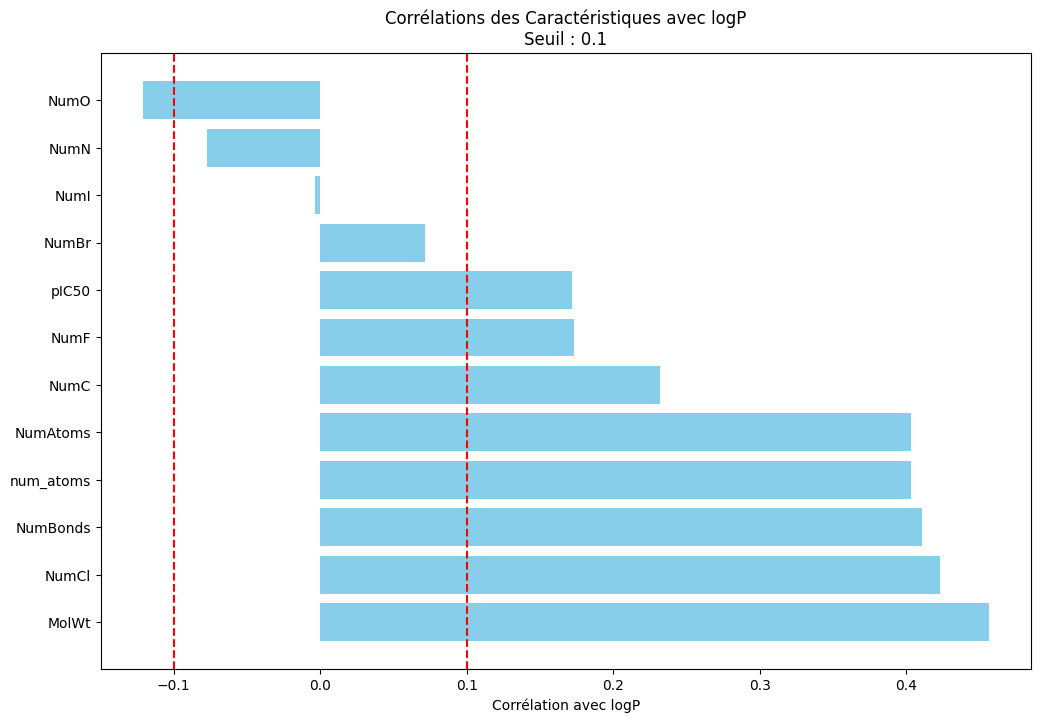

In [15]:
# Plot feature correlations with pIC50 and logP
plot_feature_correlations(data_with_features, 'pIC50', output_path="feature_correlations_pic50.png")
plot_feature_correlations(data_with_features, 'logP', output_path="feature_correlations_logP.png")

In [16]:
# Hyperparameter tuning for Neural Network (pIC50)
if model_exists('models/nn_model_pic50.pth'):
    nn_model_pic50 = NeuralNetworkModel(input_size=X_train.shape[1], hidden_sizes=[64, 32])  # Initialize with dummy sizes
    nn_model_pic50.load_model('models/nn_model_pic50.pth')
    print("Loaded existing pIC50 model.")
else:
    tuner_pic50 = HyperparameterTuning(X_train, y_train_pic50, "Neural Network")
    best_params_pic50 = tuner_pic50.tune(n_trials=50)
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_pic50[f"hidden_size_{i}"] for i in range(best_params_pic50["hidden_layers"])],
        lr=best_params_pic50["lr"],
        epochs=best_params_pic50["epochs"],
        batch_size=best_params_pic50["batch_size"],
        patience=best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    torch.save(nn_model_pic50.model.state_dict(), 'models/nn_model_pic50.pth')
    print(f"Neural Network Model MSE for pIC50: {nn_model_pic50.evaluate(X_test, y_test_pic50)}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")


RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	Unexpected key(s) in state_dict: "network.6.weight", "network.6.bias". 
	size mismatch for network.0.weight: copying a param with shape torch.Size([103, 11]) from checkpoint, the shape in current model is torch.Size([64, 11]).
	size mismatch for network.0.bias: copying a param with shape torch.Size([103]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for network.2.weight: copying a param with shape torch.Size([169, 103]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for network.2.bias: copying a param with shape torch.Size([169]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for network.4.weight: copying a param with shape torch.Size([170, 169]) from checkpoint, the shape in current model is torch.Size([1, 32]).
	size mismatch for network.4.bias: copying a param with shape torch.Size([170]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:
# Hyperparameter tuning for Neural Network (logP)
if model_exists('models/nn_model_logP.pth'):
    nn_model_logP = NeuralNetworkModel(input_size=X_train.shape[1], hidden_sizes=[64, 32])  # Initialize with dummy sizes
    nn_model_logP.load_model('models/nn_model_logP.pth')
    print("Loaded existing logP model.")
else:
    tuner_logP = HyperparameterTuning(X_train, y_train_logP, "Neural Network")
    best_params_logP = tuner_logP.tune(n_trials=50)
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_logP[f"hidden_size_{i}"] for i in range(best_params_logP["hidden_layers"])],
        lr=best_params_logP["lr"],
        epochs=best_params_logP["epochs"],
        batch_size=best_params_logP["batch_size"],
        patience=best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    torch.save(nn_model_logP.model.state_dict(), 'models/nn_model_logP.pth')
    print(f"Neural Network Model MSE for logP: {nn_model_logP.evaluate(X_test, y_test_logP)}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")

In [ ]:
# Hyperparameter tuning and model training for KNN (pIC50)
if model_exists('models/knn_model_pic50.pkl'):
    knn_model_pic50 = joblib.load('models/knn_model_pic50.pkl')
    print("Loaded existing pIC50 KNN model.")
else:
    tuner_pic50_knn = HyperparameterTuning(X_train, y_train_pic50, "KNN")
    best_params_pic50_knn = tuner_pic50_knn.tune(n_trials=50)
    knn_model_pic50 = BaselineKNN(n_neighbors=best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(knn_model_pic50, 'models/knn_model_pic50.pkl')
    print(f"KNN Model MSE for pIC50: {knn_model_pic50.evaluate(X_test, y_test_pic50)}")

In [ ]:
# Hyperparameter tuning and model training for KNN (logP)
if model_exists('models/knn_model_logP.pkl'):
    knn_model_logP = joblib.load('models/knn_model_logP.pkl')
    print("Loaded existing logP KNN model.")
else:
    tuner_logP_knn = HyperparameterTuning(X_train, y_train_logP, "KNN")
    best_params_logP_knn = tuner_logP_knn.tune(n_trials=50)
    knn_model_logP = BaselineKNN(n_neighbors=best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    joblib.dump(knn_model_logP, 'models/knn_model_logP.pkl')
    print(f"KNN Model MSE for logP: {knn_model_logP.evaluate(X_test, y_test_logP)}")

In [ ]:
# Hyperparameter tuning and model training for Random Forest (pIC50)
if model_exists('models/rf_model_pic50.pkl'):
    rf_model_pic50 = joblib.load('models/rf_model_pic50.pkl')
    print("Loaded existing pIC50 Random Forest model.")
else:
    tuner_pic50_rf = HyperparameterTuning(X_train, y_train_pic50, "Random Forest")
    best_params_pic50_rf = tuner_pic50_rf.tune(n_trials=50)
    rf_model_pic50 = RandomForestModel(n_estimators=best_params_pic50_rf["n_estimators"], max_depth=best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(rf_model_pic50, 'models/rf_model_pic50.pkl')
    print(f"Random Forest Model MSE for pIC50: {rf_model_pic50.evaluate(X_test, y_test_pic50)}")

In [ ]:
# Hyperparameter tuning and model training for Random Forest (logP)
if model_exists('models/rf_model_logP.pkl'):
    rf_model_logP = joblib.load('models/rf_model_logP.pkl')
    print("Loaded existing logP Random Forest model.")
else:
    tuner_logP_rf = HyperparameterTuning(X_train, y_train_logP, "Random Forest")
    best_params_logP_rf = tuner_logP_rf.tune(n_trials=50)
    rf_model_logP = RandomForestModel(n_estimators=best_params_logP_rf["n_estimators"], max_depth=best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    joblib.dump(rf_model_logP, 'models/rf_model_logP.pkl')
    print(f"Random Forest Model MSE for logP: {rf_model_logP.evaluate(X_test, y_test_logP)}")

In [ ]:
# Hyperparameter tuning and model training for Gradient Boosting (pIC50)
if model_exists('models/gb_model_pic50.pkl'):
    gb_model_pic50 = joblib.load('models/gb_model_pic50.pkl')
    print("Loaded existing pIC50 Gradient Boosting model.")
else:
    tuner_pic50_gb = HyperparameterTuning(X_train, y_train_pic50, "Gradient Boosting")
    best_params_pic50_gb = tuner_pic50_gb.tune(n_trials=50)
    gb_model_pic50 = GradientBoostingModel(n_estimators=best_params_pic50_gb["n_estimators"], learning_rate=best_params_pic50_gb["learning_rate"], max_depth=best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(gb_model_pic50, 'models/gb_model_pic50.pkl')
    print(f"Gradient Boosting Model MSE for pIC50: {gb_model_pic50.evaluate(X_test, y_test_pic50)}")

In [ ]:
# Hyperparameter tuning and model training for Gradient Boosting (logP)
if model_exists('models/gb_model_logP.pkl'):
    gb_model_logP = joblib.load('models/gb_model_logP.pkl')
    print("Loaded existing logP Gradient Boosting model.")
else:
    tuner_logP_gb = HyperparameterTuning(X_train, y_train_logP, "Gradient Boosting")
    best_params_logP_gb = tuner_logP_gb.tune(n_trials=50)
    gb_model_logP = GradientBoostingModel(n_estimators=best_params_logP_gb["n_estimators"], learning_rate=best_params_logP_gb["learning_rate"], max_depth=best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    joblib.dump(gb_model_logP, 'models/gb_model_logP.pkl')
    print(f"Gradient Boosting Model MSE for logP: {gb_model_logP.evaluate(X_test, y_test_logP)}")


In [ ]:
# Results visualization for pIC50
results_pic50 = {
    "Neural Network": nn_model_pic50.evaluate(X_test, y_test_pic50),
    "KNN": knn_model_pic50.evaluate(X_test, y_test_pic50),
    "Random Forest": rf_model_pic50.evaluate(X_test, y_test_pic50),
    "Gradient Boosting": gb_model_pic50.evaluate(X_test, y_test_pic50)
}

In [ ]:
# Results visualization for logP
results_logP = {
    "Neural Network": nn_model_logP.evaluate(X_test, y_test_logP),
    "KNN": knn_model_logP.evaluate(X_test, y_test_logP),
    "Random Forest": rf_model_logP.evaluate(X_test, y_test_logP),
    "Gradient Boosting": gb_model_logP.evaluate(X_test, y_test_logP)
}

In [ ]:
# Results visualization for pIC50
plot_results(results_pic50)

In [ ]:
# Results visualization for logP
plot_results(results_logP)

In [ ]:
# Visualize training processes for all models (pIC50)
# plot_multiple_training_processes(training_losses_pic50, validation_losses_pic50)


In [ ]:
# Visualize training processes for all models (logP)
# plot_multiple_training_processes(training_losses_logP, validation_losses_logP)
